In [ ]:
import os, h5py, re, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.grid"] = False

In [ ]:
# ✏️ Update this to the file you want to analyze
H5_PATH = Path("../data/hdf5_data_final/t15.2023.08.13/data_train.hdf5")
assert H5_PATH.exists(), f"Not found: {H5_PATH}"
H5_PATH

In [ ]:
rows = []
with h5py.File(H5_PATH, "r") as f:
    for trial_key in f.keys():
        g = f[trial_key]
    
        input_features = g['input_features'][:]
        n_time_steps = g.attrs['n_time_steps']
        seq_class_ids = g['seq_class_ids'][:] if 'seq_class_ids' in g else None
        seq_len = g.attrs['seq_len'] if 'seq_len' in g.attrs else None
        transcription = g['transcription'][:] if 'transcription' in g else None
        sentence_label = g.attrs['sentence_label'][:] if 'sentence_label' in g.attrs else None
        session = g.attrs['session']
        block_num = g.attrs['block_num']
        trial_num = g.attrs['trial_num']

        rows.append({
            "trial_key": trial_key,
            "session": session,
            "block_num": block_num,
            "trial_num": trial_num,
            "n_time_steps": n_time_steps,
            # "seq_class_ids": seq_class_ids, - byte array
            "seq_len": seq_len,
            # "transcription": transcription, - byte array
            "sentence_label": sentence_label,
            "word_count": len(sentence_label.split())
        })

df_trials = pd.DataFrame(rows)
df_trials.head()

In [ ]:
# Create additional columns
df_trials["duration_sec"] = df_trials["n_time_steps"] * 0.02
df_trials["char_count"] = df_trials["sentence_label"].str.len()

In [ ]:
# Explore distributions

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15,4))

axes[0].hist(df_trials["duration_sec"], bins=40)
axes[0].set_title("Trial duration (seconds)")

axes[1].hist(df_trials["word_count"], bins=30)
axes[1].set_title("Sentence word counts")

axes[2].hist(df_trials["char_count"], bins=30)
axes[2].set_title("Sentence character counts")

plt.tight_layout()
plt.show()

In [ ]:
# Relationships between inputs and outputs
plt.figure(figsize=(6,4))
plt.scatter(df_trials["word_count"], df_trials["duration_sec"], alpha=0.5, s=10)
plt.xlabel("Word count")
plt.ylabel("Trial duration (seconds)")
plt.title("Trial duration vs sentence length")
plt.show()

In [ ]:
# Shortest / longest by duration
print("Shortest trials:")
display(df_trials.nsmallest(5, "duration_sec")[["trial_key","duration_sec","sentence_label"]])

print("\nLongest trials:")
display(df_trials.nlargest(5, "duration_sec")[["trial_key","duration_sec","sentence_label"]])

# Shortest / longest by word count
print("Fewest words:")
display(df_trials.nsmallest(5, "word_count")[["trial_key","word_count","sentence_label"]])

print("\nMost words:")
display(df_trials.nlargest(5, "word_count")[["trial_key","word_count","sentence_label"]])

# Shortest / longest by character count
print("\nFewest characters:")
display(df_trials.nsmallest(5, "char_count")[["trial_key","char_count","sentence_label"]])

print("\nMost characters:")
display(df_trials.nlargest(5, "char_count")[["trial_key","char_count","sentence_label"]])


In [ ]:
# Sentence Content Correlation
df_trials[["n_time_steps","word_count","char_count"]].corr()

In [ ]:
df_trials.groupby("block_num")["duration_sec"].mean().plot(kind="bar", figsize=(8,4))
plt.ylabel("Avg trial duration (s)")
plt.title("Average trial length by block")
plt.show()

In [2]:
import h5py, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display

In [3]:
H5_PATH = Path("../data/hdf5_data_final/t15.2023.08.18/data_train.hdf5")  # adjust if path differs
assert H5_PATH.exists(), f"File not found: {H5_PATH}"
H5_PATH

WindowsPath('../data/hdf5_data_final/t15.2023.08.18/data_train.hdf5')

In [4]:
def safe_decode(x):
    """Decode bytes/np scalars into str, handle None."""
    if x is None:
        return None
    if isinstance(x, bytes):
        return x.decode("utf-8", errors="replace")
    if isinstance(x, np.ndarray) and x.shape == () and x.dtype.kind in ("S","O"):
        try:
            return x.tobytes().decode("utf-8", errors="replace")
        except:
            return str(x)
    return str(x)

In [5]:
# ---- Step 3. Iterate over trials ----
rows = []
with h5py.File(H5_PATH, "r") as f:
    for trial_key in f.keys():
        g = f[trial_key]
        
        # Metadata
        n_time_steps = g.attrs.get("n_time_steps", np.nan)
        seq_len = g.attrs.get("seq_len", np.nan)
        sentence_label = safe_decode(g.attrs.get("sentence_label", None))
        session = g.attrs.get("session", None)
        block_num = g.attrs.get("block_num", None)
        trial_num = g.attrs.get("trial_num", None)
        
        # Only grab shapes, not full arrays (saves memory)
        feat_shape = g["input_features"].shape if "input_features" in g else None
        seq_class_shape = g["seq_class_ids"].shape if "seq_class_ids" in g else None
        
        rows.append({
            "trial_key": trial_key,
            "session": session,
            "block_num": block_num,
            "trial_num": trial_num,
            "n_time_steps": n_time_steps,
            "seq_len": seq_len,
            "sentence_label": sentence_label,
            "word_count": len(sentence_label.split()) if sentence_label else 0,
            "char_count": len(sentence_label) if sentence_label else 0,
            "feat_shape": feat_shape,
            "seq_class_shape": seq_class_shape
        })

df = pd.DataFrame(rows)
print("Shape of DataFrame:", df.shape)
display(df.head())

Shape of DataFrame: (197, 11)


,trial_key,session,block_num,trial_num,n_time_steps,seq_len,sentence_label,word_count,char_count,feat_shape,seq_class_shape
0,trial_0000,t15.2023.08.18,4,0,486,21,It's going to continue.,4,23,"(486, 512)","(500,)"
1,trial_0001,t15.2023.08.18,4,1,1162,42,Aluminum foil has a shiny side and a dull side.,10,47,"(1162, 512)","(500,)"
2,trial_0002,t15.2023.08.18,4,2,975,29,Well maybe I'll get you next time.,7,34,"(975, 512)","(500,)"
3,trial_0003,t15.2023.08.18,4,3,718,25,They don't have oil or anything.,6,32,"(718, 512)","(500,)"
4,trial_0004,t15.2023.08.18,4,4,591,21,The commercial districts.,3,25,"(591, 512)","(500,)"


In [6]:
# ---- Step 4. Derived features ----
df["duration_sec"] = df["n_time_steps"].astype(float) * 0.02

In [7]:
# ---- Step 5. Summary stats ----
print("\n=== Summary Statistics ===")
display(df.describe(include="all"))


=== Summary Statistics ===


,trial_key,session,block_num,trial_num,n_time_steps,seq_len,sentence_label,word_count,char_count,feat_shape,seq_class_shape,duration_sec
count,197,197,197.000000,197.000000,197.000000,197.000000,197,197.000000,197.000000,197,197,197.000000
unique,197,1,NaN,NaN,NaN,NaN,197,NaN,NaN,175,1,NaN
top,trial_0000,t15.2023.08.18,NaN,NaN,NaN,NaN,It's going to continue.,NaN,NaN,"(765, 512)","(500,)",NaN
freq,1,197,NaN,NaN,NaN,NaN,1,NaN,NaN,3,197,NaN
mean,NaN,NaN,6.527919,24.583756,885.522843,26.802030,NaN,6.294416,31.522843,NaN,NaN,17.710457
std,NaN,NaN,2.069083,14.477968,241.060869,8.065826,NaN,2.018946,9.214880,NaN,NaN,4.821217
min,NaN,NaN,4.000000,0.000000,361.000000,11.000000,NaN,2.000000,14.000000,NaN,NaN,7.220000
25%,NaN,NaN,5.000000,12.000000,718.000000,21.000000,NaN,5.000000,24.000000,NaN,NaN,14.360000
50%,NaN,NaN,8.000000,25.000000,851.000000,26.000000,NaN,6.000000,31.000000,NaN,NaN,17.020000
75%,NaN,NaN,9.000000,37.000000,1026.000000,33.000000,NaN,8.000000,39.000000,NaN,NaN,20.520000


In [8]:
print("\nMissing values (%):")
display(df.isna().mean() * 100)


Missing values (%):


trial_key          0.0
session            0.0
block_num          0.0
trial_num          0.0
n_time_steps       0.0
seq_len            0.0
sentence_label     0.0
word_count         0.0
char_count         0.0
feat_shape         0.0
seq_class_shape    0.0
duration_sec       0.0
dtype: float64

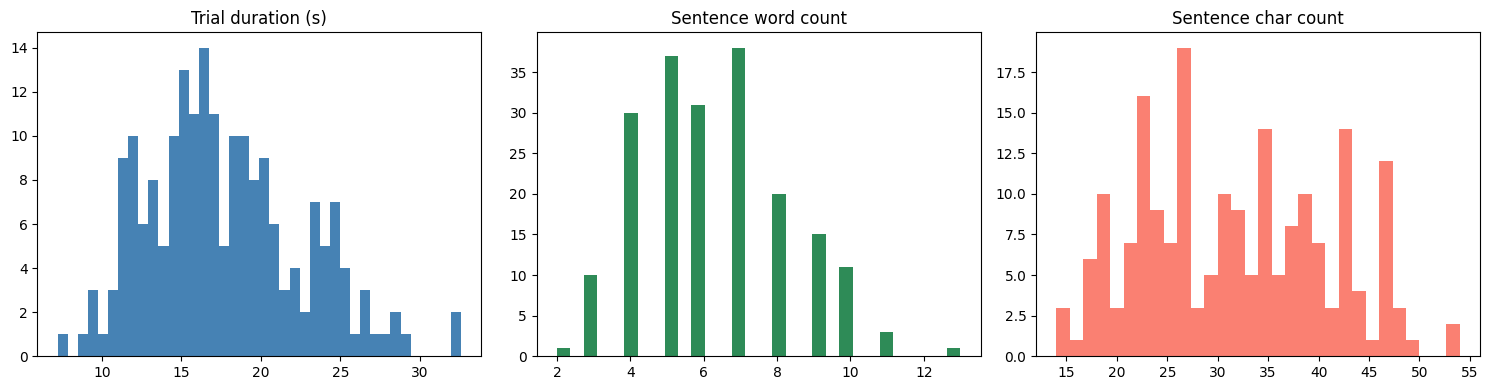

In [9]:
# ---- Step 6. Histograms ----
fig, axes = plt.subplots(1, 3, figsize=(15,4))
axes[0].hist(df["duration_sec"].dropna(), bins=40, color="steelblue")
axes[0].set_title("Trial duration (s)")

axes[1].hist(df["word_count"].dropna(), bins=30, color="seagreen")
axes[1].set_title("Sentence word count")

axes[2].hist(df["char_count"].dropna(), bins=30, color="salmon")
axes[2].set_title("Sentence char count")

plt.tight_layout()
plt.show()

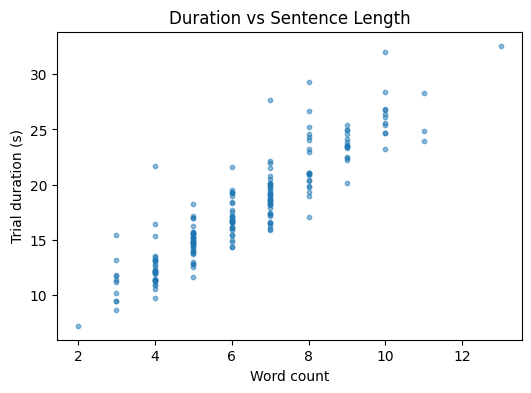

In [10]:
# ---- Step 7. Relationships ----
plt.figure(figsize=(6,4))
plt.scatter(df["word_count"], df["duration_sec"], alpha=0.5, s=10)
plt.xlabel("Word count")
plt.ylabel("Trial duration (s)")
plt.title("Duration vs Sentence Length")
plt.show()


In [11]:
# ---- Step 8. Extremes ----
print("\nShortest trials by duration:")
display(df.nsmallest(5, "duration_sec")[["trial_key","duration_sec","sentence_label"]])

print("\nLongest trials by duration:")
display(df.nlargest(5, "duration_sec")[["trial_key","duration_sec","sentence_label"]])

print("\nFewest words:")
display(df.nsmallest(5, "word_count")[["trial_key","word_count","sentence_label"]])

print("\nMost words:")
display(df.nlargest(5, "word_count")[["trial_key","word_count","sentence_label"]])


Shortest trials by duration:


,trial_key,duration_sec,sentence_label
185,trial_0185,7.22,Avoid routine.
62,trial_0062,8.60,Cover his ears.
68,trial_0068,9.46,When they graduate.
131,trial_0131,9.50,It always sounded.
0,trial_0000,9.72,It's going to continue.



Longest trials by duration:


,trial_key,duration_sec,sentence_label
164,trial_0164,32.58,I guess I need to put it on paper and turn it in.
6,trial_0006,32.00,Four year old Subaru and a two year old Honda.
11,trial_0011,29.28,They've not had to do that all year.
144,trial_0144,28.38,"In many ways, each genre is a sport unto itself."
166,trial_0166,28.32,Don't you have to do it as part of its decision?



Fewest words:


,trial_key,word_count,sentence_label
185,trial_0185,2,Avoid routine.
4,trial_0004,3,The commercial districts.
14,trial_0014,3,Well that's good.
62,trial_0062,3,Cover his ears.
68,trial_0068,3,When they graduate.



Most words:


,trial_key,word_count,sentence_label
164,trial_0164,13,I guess I need to put it on paper and turn it in.
78,trial_0078,11,It was a point of honour with us not to whine.
166,trial_0166,11,Don't you have to do it as part of its decision?
192,trial_0192,11,Where do you have to do a whole bunch of work?
1,trial_0001,10,Aluminum foil has a shiny side and a dull side.


In [12]:
# ---- Step 9. Correlation ----
print("\nCorrelation matrix:")
display(df[["n_time_steps","word_count","char_count"]].corr())


Correlation matrix:


,n_time_steps,word_count,char_count
n_time_steps,1.000000,0.910323,0.846334
word_count,0.910323,1.000000,0.872540
char_count,0.846334,0.872540,1.000000


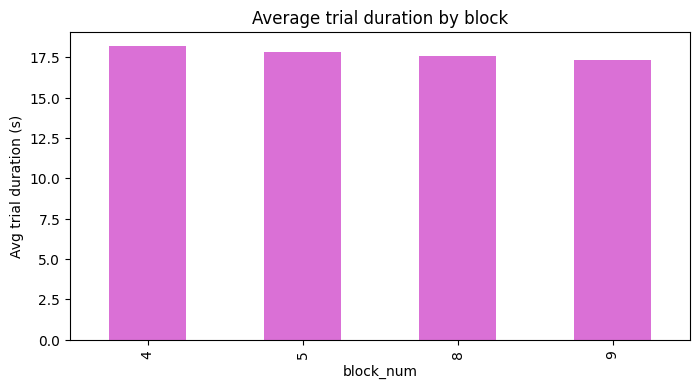

In [13]:
# ---- Step 10. Block-level analysis ----
df.groupby("block_num")["duration_sec"].mean().plot(kind="bar", figsize=(8,4), color="orchid")
plt.ylabel("Avg trial duration (s)")
plt.title("Average trial duration by block")
plt.show()

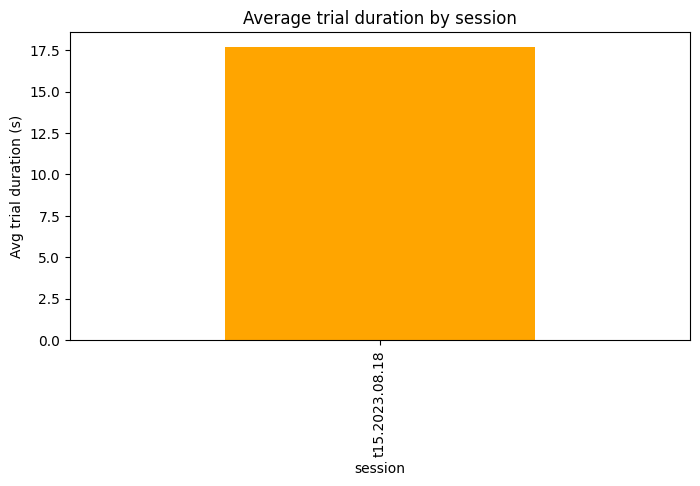

In [14]:
# ---- Step 11. Session-level analysis ----
if "session" in df.columns:
    df.groupby("session")["duration_sec"].mean().plot(kind="bar", figsize=(8,4), color="orange")
    plt.ylabel("Avg trial duration (s)")
    plt.title("Average trial duration by session")
    plt.show()

In [7]:
import os, re, h5py, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display, Markdown

In [8]:
# ---- File path----
H5_PATH = Path("../data/hdf5_data_final/t15.2023.08.20/data_train.hdf5")   # <-- keep this simple
assert H5_PATH.exists(), f"File not found: {H5_PATH}"

STEP_SEC = 0.02  # 20 ms per step

In [9]:
def safe_decode(x):
    """Turn bytes/np scalar/None into str safely."""
    if x is None: return None
    if isinstance(x, bytes): return x.decode("utf-8", errors="replace")
    if isinstance(x, np.ndarray) and x.shape == () and x.dtype.kind in ("S","O"):
        try: return x.tobytes().decode("utf-8", errors="replace")
        except: return str(x)
    return str(x)

In [10]:
rows = []
with h5py.File(H5_PATH, "r") as f:
    for trial_key in f.keys():
        g = f[trial_key]

        n_time_steps = g.attrs.get("n_time_steps", np.nan)
        seq_len      = g.attrs.get("seq_len", np.nan)
        sentence     = safe_decode(g.attrs.get("sentence_label", None))
        session      = g.attrs.get("session", None)
        block_num    = g.attrs.get("block_num", None)
        trial_num    = g.attrs.get("trial_num", None)

        # Don’t load big arrays; just record shapes
        feat_shape     = g["input_features"].shape if "input_features" in g else None
        seq_ids_shape  = g["seq_class_ids"].shape if "seq_class_ids" in g else None
        trans_shape    = g["transcription"].shape if "transcription" in g else None

        rows.append({
            "trial_key": trial_key,
            "session": session,
            "block_num": block_num,
            "trial_num": trial_num,
            "n_time_steps": n_time_steps,
            "seq_len": seq_len,
            "sentence_label": sentence,
            "word_count": len(sentence.split()) if sentence else 0,
            "char_count": len(sentence) if sentence else 0,
            "feat_shape": feat_shape,
            "seq_class_shape": seq_ids_shape,
            "transcription_shape": trans_shape,
        })

In [11]:
df = pd.DataFrame(rows).sort_values("trial_key").reset_index(drop=True)
print("Trials:", df.shape[0])
display(df.head())

Trials: 278


,trial_key,session,block_num,trial_num,n_time_steps,seq_len,sentence_label,word_count,char_count,feat_shape,seq_class_shape,transcription_shape
0,trial_0000,t15.2023.08.20,1,0,921,33,I should be able to do things like this.,9,40,"(921, 512)","(500,)","(500,)"
1,trial_0001,t15.2023.08.20,1,1,449,16,It was beautiful.,3,17,"(449, 512)","(500,)","(500,)"
2,trial_0002,t15.2023.08.20,1,2,757,23,We have a seven year old.,6,25,"(757, 512)","(500,)","(500,)"
3,trial_0003,t15.2023.08.20,1,3,383,13,Meet my pleasure.,3,17,"(383, 512)","(500,)","(500,)"
4,trial_0004,t15.2023.08.20,1,4,673,20,"Ok, so what's the point?",5,24,"(673, 512)","(500,)","(500,)"


In [12]:
# ---- Derived features + quick QA ----
df["duration_sec"] = df["n_time_steps"].astype(float) * STEP_SEC
df["feat_T"] = df["feat_shape"].apply(lambda s: (s[0] if isinstance(s, tuple) and len(s)>0 else np.nan))
df["feat_F"] = df["feat_shape"].apply(lambda s: (s[1] if isinstance(s, tuple) and len(s)>1 else np.nan))

Markdown("### Summary statistics (numeric)")
display(df[["n_time_steps","seq_len","word_count","char_count","duration_sec","feat_T","feat_F"]].describe())

Markdown("### Missing values (%)")
display((df.isna().mean()*100).round(2).sort_values(ascending=False))

,n_time_steps,seq_len,word_count,char_count,duration_sec,feat_T,feat_F
count,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.0
mean,797.992806,26.399281,6.140288,30.964029,15.959856,797.992806,512.0
std,238.769574,8.539287,2.015758,9.963768,4.775391,238.769574,0.0
min,378.000000,11.000000,2.000000,13.000000,7.560000,378.000000,512.0
25%,617.750000,19.000000,4.000000,22.250000,12.355000,617.750000,512.0
50%,765.500000,26.000000,6.000000,30.000000,15.310000,765.500000,512.0
75%,953.500000,31.000000,7.000000,37.000000,19.070000,953.500000,512.0
max,1735.000000,58.000000,12.000000,70.000000,34.700000,1735.000000,512.0


trial_key              0.0
session                0.0
block_num              0.0
trial_num              0.0
n_time_steps           0.0
seq_len                0.0
sentence_label         0.0
word_count             0.0
char_count             0.0
feat_shape             0.0
seq_class_shape        0.0
transcription_shape    0.0
duration_sec           0.0
feat_T                 0.0
feat_F                 0.0
dtype: float64

In [13]:
# ---- Alignment checks (sanity) ----
mm_feat = df[(~pd.isna(df["feat_T"])) & (df["feat_T"] != df["n_time_steps"])]
ms_seq  = df[(~pd.isna(df["seq_len"])) & (df["seq_len"] != df["n_time_steps"])]

print(f"feat_T vs n_time_steps mismatches: {mm_feat.shape[0]}")
display(mm_feat[["trial_key","n_time_steps","feat_T"]].head(10))

print(f"seq_len vs n_time_steps mismatches: {ms_seq.shape[0]}")
display(ms_seq[["trial_key","n_time_steps","seq_len"]].head(10))


feat_T vs n_time_steps mismatches: 0


,trial_key,n_time_steps,feat_T


seq_len vs n_time_steps mismatches: 278


,trial_key,n_time_steps,seq_len
0,trial_0000,921,33
1,trial_0001,449,16
2,trial_0002,757,23
3,trial_0003,383,13
4,trial_0004,673,20
5,trial_0005,1078,41
6,trial_0006,481,16
7,trial_0007,763,30
8,trial_0008,753,35
9,trial_0009,815,26


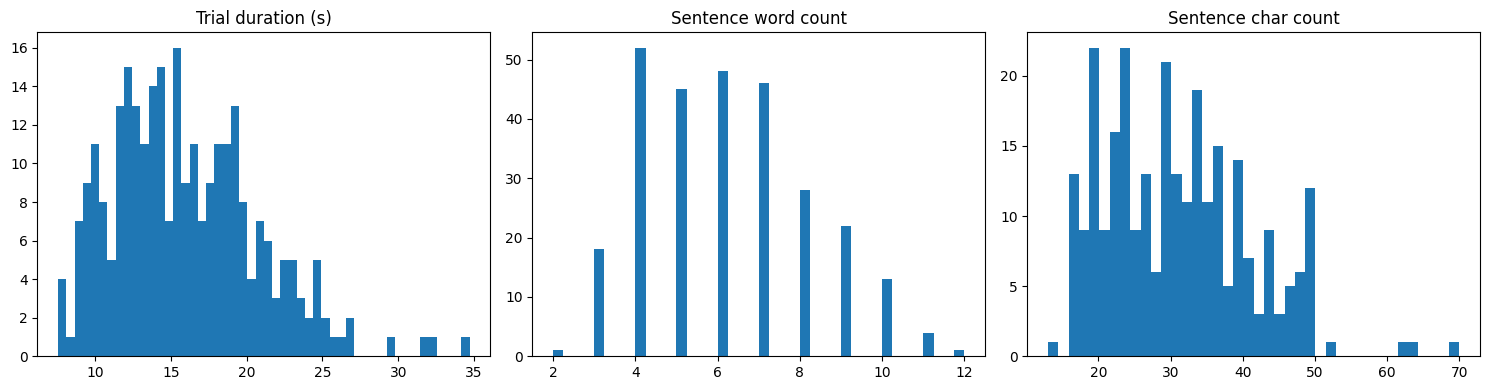

In [14]:
# ---- Distributions ----
fig, axes = plt.subplots(1, 3, figsize=(15,4))

axes[0].hist(df["duration_sec"].dropna(), bins=50)
axes[0].set_title("Trial duration (s)")

axes[1].hist(df["word_count"].dropna(), bins=40)
axes[1].set_title("Sentence word count")

axes[2].hist(df["char_count"].dropna(), bins=40)
axes[2].set_title("Sentence char count")

plt.tight_layout(); plt.show()


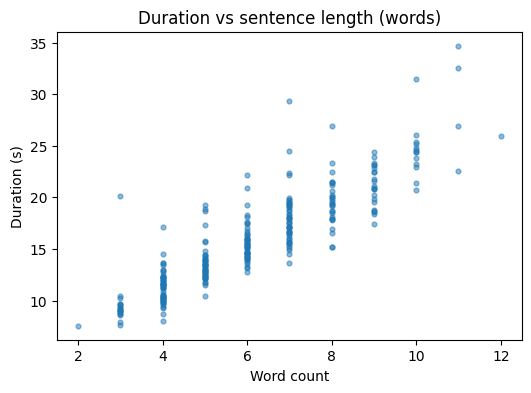

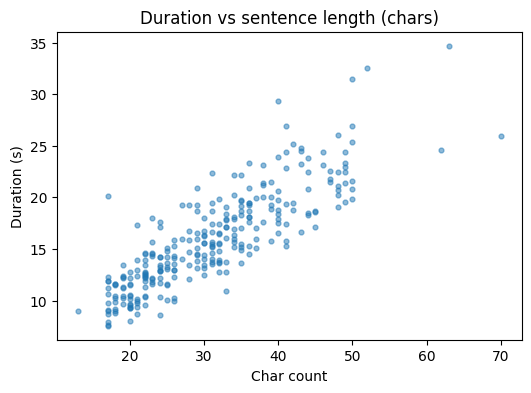

,n_time_steps,word_count,char_count,duration_sec,feat_T,feat_F
n_time_steps,1.000,0.884,0.845,1.000,1.000,NaN
word_count,0.884,1.000,0.888,0.884,0.884,NaN
char_count,0.845,0.888,1.000,0.845,0.845,NaN
duration_sec,1.000,0.884,0.845,1.000,1.000,NaN
feat_T,1.000,0.884,0.845,1.000,1.000,NaN
feat_F,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# ---- Relationships ----
plt.figure(figsize=(6,4))
plt.scatter(df["word_count"], df["duration_sec"], alpha=0.5, s=12)
plt.xlabel("Word count"); plt.ylabel("Duration (s)")
plt.title("Duration vs sentence length (words)")
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(df["char_count"], df["duration_sec"], alpha=0.5, s=12)
plt.xlabel("Char count"); plt.ylabel("Duration (s)")
plt.title("Duration vs sentence length (chars)")
plt.show()

Markdown("### Correlation matrix")
display(df[["n_time_steps","word_count","char_count","duration_sec","feat_T","feat_F"]].corr().round(3))


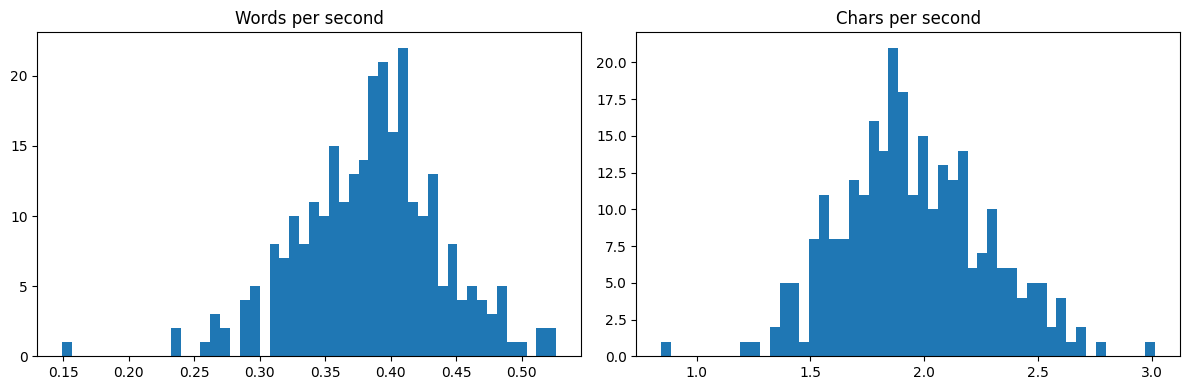

In [16]:
# ---- Speaking-rate style features ----
df["wps"] = np.where(df["duration_sec"]>0, df["word_count"]/df["duration_sec"], np.nan)
df["cps"] = np.where(df["duration_sec"]>0, df["char_count"]/df["duration_sec"], np.nan)

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].hist(df["wps"].dropna(), bins=50); ax[0].set_title("Words per second")
ax[1].hist(df["cps"].dropna(), bins=50); ax[1].set_title("Chars per second")
plt.tight_layout(); plt.show()


In [17]:
# ---- Extremes (quick surface of examples) ----
Markdown("**Shortest trials (by duration):**")
display(df.nsmallest(5, "duration_sec")[["trial_key","duration_sec","sentence_label"]])

Markdown("**Longest trials (by duration):**")
display(df.nlargest(5, "duration_sec")[["trial_key","duration_sec","sentence_label"]])

Markdown("**Fewest words:**")
display(df.nsmallest(5, "word_count")[["trial_key","word_count","sentence_label"]])

Markdown("**Most words:**")
display(df.nlargest(5, "word_count")[["trial_key","word_count","sentence_label"]])


,trial_key,duration_sec,sentence_label
146,trial_0146,7.56,It's situational.
3,trial_0003,7.66,Meet my pleasure.
43,trial_0043,7.88,It's still green.
36,trial_0036,8.06,They'd soon be back.
112,trial_0112,8.58,That's excellent advice.


,trial_key,duration_sec,sentence_label
211,trial_0211,34.70,It's the first and only time I've done somethi...
153,trial_0153,32.52,I didn't used to but now I eat cereal every mo...
255,trial_0255,31.48,It's very tedious if you don't have a whole gr...
263,trial_0263,29.34,A salesperson will usually want to know.
214,trial_0214,26.94,They should have one year and one appeal.


,trial_key,word_count,sentence_label
146,trial_0146,2,It's situational.
1,trial_0001,3,It was beautiful.
3,trial_0003,3,Meet my pleasure.
6,trial_0006,3,Detroit Free Press.
43,trial_0043,3,It's still green.


,trial_key,word_count,sentence_label
120,trial_0120,12,"If they had a jury of psychiatrists instead, w..."
30,trial_0030,11,Is it a way of raising the prices of illegal g...
138,trial_0138,11,I don't read as much as I would like to either.
153,trial_0153,11,I didn't used to but now I eat cereal every mo...
211,trial_0211,11,It's the first and only time I've done somethi...


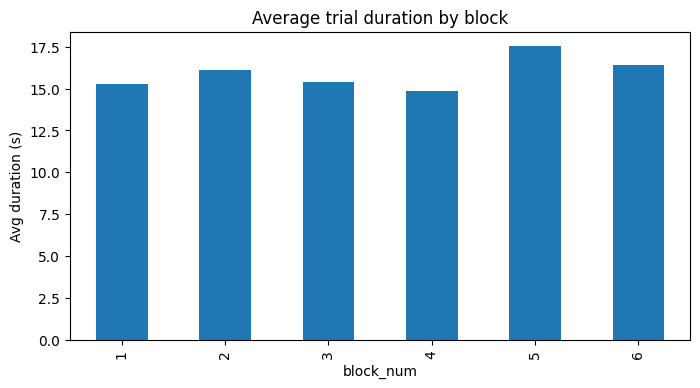

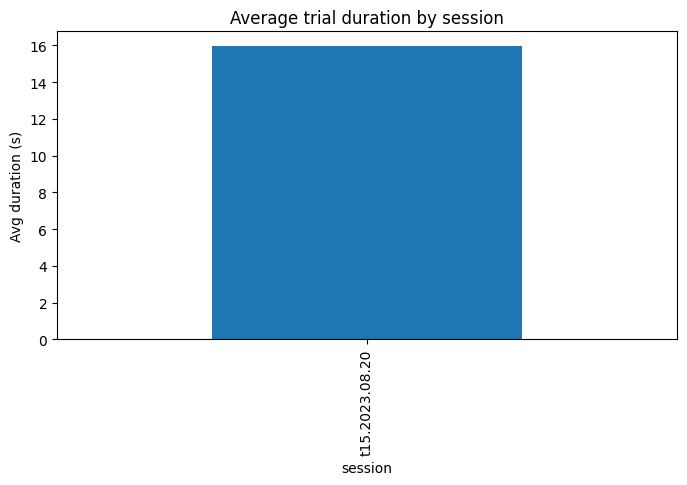

In [18]:
# ---- Block / Session patterns ----
if "block_num" in df.columns:
    df.groupby("block_num")["duration_sec"].mean().plot(kind="bar", figsize=(8,4))
    plt.ylabel("Avg duration (s)"); plt.title("Average trial duration by block")
    plt.show()

if "session" in df.columns:
    df.groupby("session")["duration_sec"].mean().plot(kind="bar", figsize=(8,4))
    plt.ylabel("Avg duration (s)"); plt.title("Average trial duration by session")
    plt.show()


In [19]:
# ---- Outliers via IQR ----
q1, q3 = df["duration_sec"].quantile([0.25, 0.75])
iqr = q3 - q1
lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
outliers = df[(df["duration_sec"] < lo) | (df["duration_sec"] > hi)]
print(f"Duration outliers: {outliers.shape[0]}  | bounds ~ ({lo:.3f}, {hi:.3f})")
display(outliers[["trial_key","duration_sec","word_count","char_count","sentence_label"]].head(10))

Duration outliers: 4  | bounds ~ (2.283, 29.142)


,trial_key,duration_sec,word_count,char_count,sentence_label
153,trial_0153,32.52,11,52,I didn't used to but now I eat cereal every mo...
211,trial_0211,34.70,11,63,It's the first and only time I've done somethi...
255,trial_0255,31.48,10,50,It's very tedious if you don't have a whole gr...
263,trial_0263,29.34,7,40,A salesperson will usually want to know.
